In [244]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import prince
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

## Data Preparation for the model

In [444]:
pd.set_option('display.max_columns', 500)

In [445]:
df = pd.read_csv('/Users/naitochieri/Desktop/Hackathon/Datasets/combined.csv')

In [446]:
df.columns

Index(['Unnamed: 0', 'index', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'account_id_x',
       'vertical', 'industry', 'client_country', 'unique_client',
       'client_continent', 'client_region', 'OS', 'device', 'environment',
       'criteo_product', 'month', 'time', 'year', 'spend_criteo_euro',
       'sales_criteo', 'CPO', 'revenue_criteo_euro', 'AOV', 'COS',
       'churn_date', 'churn', 'start_time', 'Android', 'MacOS', 'Other',
       'Unknown_x', 'iOs', 'Desktop', 'Mobile', 'Unknown_y', 'app', 'web',
       'awareness', 'consideration', 'conversion', 'account_id_y', 'products',
       'account_id', 'onsite_sales', 'onsite_revenue_euro'],
      dtype='object')

In [447]:
X = df[['unique_client','month', 'time', 'vertical', 'industry', 'client_country',
       'client_continent', 'client_region', 'OS', 'device', 'environment',
       'criteo_product', 'spend_criteo_euro', 'sales_criteo', 'CPO',
       'revenue_criteo_euro', 'AOV', 'COS', 'Android', 'MacOS', 'Other', 'iOs',
       'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration',
       'conversion', 'products', 'onsite_sales', 'onsite_revenue_euro','churn_date']]

In [448]:
df2 = df[['vertical', 'industry', 'client_country',
       'client_continent', 'client_region', 'OS', 'device',
       'environment', 'criteo_product', 'month', 'time',
         'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro',
       'AOV', 'COS', 'churn_date']]

In [449]:
for i in range(X.shape[0]):
    if X.loc[i,'churn_date'] == 0:
        X.loc[i,'churn_date'] = int(X['time'][i]) + 5.01
        
for i in range(df2.shape[0]):
    if df2.loc[i,'churn_date'] == 0:
        df2.loc[i,'churn_date'] = int(df2['time'][i]) + 5.01

In [450]:
num_cols = ['month', 'time',
         'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro',
       'AOV', 'COS']
cate_cols = df2.columns.drop('churn_date').drop(num_cols)

In [451]:
X[num_cols] = X[num_cols].apply(pd.to_numeric, errors='coerce')
X['churn_date'] = X['churn_date'].apply(pd.to_numeric, errors='coerce')

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [452]:
df2[num_cols] = df2[num_cols].apply(pd.to_numeric, errors='coerce')
df2['churn_date'] = df2['churn_date'].apply(pd.to_numeric, errors='coerce')

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [453]:
X = X.fillna(0)
df2 = df2.fillna(0)

In [454]:
eps = 1e-15
for i in range(X.shape[0]):
    number_dec_str = str(X['churn_date'][i]-int(X['churn_date'][i]))[1:]
    number_dec = float(number_dec_str)
    for j in range(1,13):
            if abs(number_dec - 0.01*j) < eps:
                X.loc[i,'churn_date'] = int(X['churn_date'][i]) + j/13

eps = 1e-15
for i in range(df2.shape[0]):
    number_dec_str = str(df2['churn_date'][i]-int(df2['churn_date'][i]))[1:]
    number_dec = float(number_dec_str)
    for j in range(1,13):
            if abs(number_dec - 0.01*j) < eps:
                df2.loc[i,'churn_date'] = int(df2['churn_date'][i]) + j/13

In [455]:
X2 = df2
X2.dtypes

vertical                object
industry                object
client_country          object
client_continent        object
client_region           object
OS                      object
device                  object
environment             object
criteo_product          object
month                    int64
time                   float64
spend_criteo_euro        int64
sales_criteo             int64
CPO                    float64
revenue_criteo_euro      int64
AOV                    float64
COS                      int64
churn_date             float64
dtype: object

In [456]:
X['country_industry'] = X['client_country'] + '_' + X['industry']
X2['country_industry'] = X2['client_country'] + '_' + X2['industry']

## Predict churn date to calculate tenure using our trained Xgboost regression model

In [258]:
import pickle
filename = 'churn_date_model.sav'
model = pickle.load(open(filename, 'rb'))

[11:33:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [259]:
def get_pred(X):
    X3 = X.drop(columns=['churn_date'])
    y = X['churn_date']
    encoder = preprocessing.LabelEncoder()
    X3['vertical'] = encoder.fit_transform(X['vertical'])
    X3['industry'] = encoder.fit_transform(X['industry'])
    X3['client_country'] = encoder.fit_transform(X['client_country'])
    X3['client_continent'] = encoder.fit_transform(X['client_continent'])
    X3['client_region'] = encoder.fit_transform(X['client_region'])
    X3['OS'] = encoder.fit_transform(X['OS'])
    X3['device'] = encoder.fit_transform(X['device'])
    X3['environment'] = encoder.fit_transform(X['environment'])
    X3['criteo_product'] = encoder.fit_transform(X['criteo_product'])
    #X3['index'] = ""
    #for i, j in X3.iterrows():
       # X3.loc[i, 'index'] = i
    cols = ['month', 'time', 'vertical', 'industry', 'client_country', 'client_continent', 'client_region', 'OS', 'device', 'environment', 'criteo_product', 'spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro', 'AOV', 'COS', 'Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration', 'conversion', 'products', 'onsite_sales', 'onsite_revenue_euro']
    X3 = X3[cols]
    
    return model.predict(X3)

In [331]:
## Identify the correct month given a churn date
def identify_month(churn_date):
    eps = 1e-15
    number_dec_str = str(churn_date-int(churn_date))[1:]
    number_dec = float(number_dec_str)
    entry = False
    for j in range(1,13):
        if (number_dec < j/13.0 or abs(number_dec - j/13) < eps) and number_dec > (j-1)/13.0:
            entry = True
            return j
    if not entry:
        return 12

In [341]:
#Identify the churn dates in the format (year, month) for all good clients in each cluster
def get_final_date(pred_list):
    final_dates = []
    for i in range(len(pred_list)):
        final_dates.append((int(pred_list[i]), identify_month(pred_list[i])))
    return final_dates

In [342]:
pred = get_pred(X)
churn_date_pred = get_final_date(pred)

In [343]:
churn_date_pred = pd.DataFrame(data=churn_date_pred, index=X.index)
churn_date_pred

,0,1
0,2022,4
1,2020,3
2,2022,4
3,2024,8
4,2021,5
...,...,...
16245,2022,6
16246,2023,1
16247,2022,12
16248,2022,4


In [335]:
churn_date_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16250 entries, 0 to 16249
Data columns (total 2 columns):
0    16250 non-null int64
1    16250 non-null int64
dtypes: int64(2)
memory usage: 254.0 KB


In [346]:
churn_date_pred[1].unique()

array([ 4,  3,  8,  5,  7,  6, 10, 11,  2,  9, 12,  1])

In [348]:
churn_date_pred[1] = churn_date_pred[1]*0.01

In [349]:
churn_date_pred = churn_date_pred[0] +  churn_date_pred[1]
churn_date_pred

0        2022.04
1        2020.03
2        2022.04
3        2024.08
4        2021.05
          ...   
16245    2022.06
16246    2023.01
16247    2022.12
16248    2022.04
16249    2022.09
Length: 16250, dtype: float64

In [351]:
X['churn_date_pred'] = churn_date_pred

In [418]:
X.head()

,unique_client,month,time,vertical,industry,client_country,client_continent,client_region,OS,device,environment,criteo_product,spend_criteo_euro,sales_criteo,CPO,revenue_criteo_euro,AOV,COS,Android,MacOS,Other,iOs,Desktop,Mobile,app,web,awareness,consideration,conversion,products,onsite_sales,onsite_revenue_euro,churn_date,country_industry,churn_date_pred,duration
0,ga_bc66d247-ae5d-e311-a5f9-005056bb7e02_RUSSIA...,3,2017.03,RETAIL,Electronics / High Tech,RUSSIAN FEDERATION,EMEA,RUSSIA,Android,Mobile,web,conversion,1030,168,6.0,22929,136.0,0,1030.0,0.0,0.0,0.0,0.0,1030.0,0.0,1030.0,0.0,0.0,1030.0,4500.0,3093.0,416103.72,2018.06,RUSSIAN FEDERATION_Electronics / High Tech,2022.04,5.01
1,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_CANADA,4,2017.04,RETAIL,Gifts & Flowers,CANADA,AMERICAS,CANADA,Android,Mobile,web,conversion,1966,4,492.0,246,61.0,8,1966.0,0.0,0.0,0.0,0.0,1966.0,0.0,1966.0,0.0,0.0,1966.0,4604.0,585.0,183438.72,2018.09,CANADA_Gifts & Flowers,2020.03,2.99
2,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_UNITED...,9,2017.09,RETAIL,Gifts & Flowers,UNITED KINGDOM,EMEA,UK,Android,Mobile,web,conversion,1377,168,8.0,8606,51.0,0,1377.0,0.0,0.0,0.0,0.0,1377.0,0.0,1377.0,0.0,0.0,1377.0,13958.0,21107.0,3858810.09,2018.05,UNITED KINGDOM_Gifts & Flowers,2022.04,4.95
3,ga_bc784dcb-17fe-e311-a3df-005056bb7e02_UNITED...,7,2019.07,RETAIL,Gifts & Flowers,UNITED STATES,AMERICAS,US,Android,Desktop,web,conversion,82,4,21.0,72,18.0,1,82.0,0.0,0.0,0.0,82.0,0.0,0.0,82.0,0.0,0.0,82.0,4990.0,82.0,11705.52,0.00,UNITED STATES_Gifts & Flowers,2024.08,5.01
4,ga_8fff21b1-4fad-e511-9606-005056bb2344_RUSSIA...,6,2017.06,RETAIL,Accessories / Jewelry / Luxury Goods,RUSSIAN FEDERATION,EMEA,RUSSIA,Android,Mobile,web,conversion,74,20,4.0,1174,59.0,0,74.0,0.0,0.0,0.0,0.0,74.0,0.0,74.0,0.0,0.0,74.0,5147.0,686.0,87426.68,2018.02,RUSSIAN FEDERATION_Accessories / Jewelry / Lux...,2021.05,3.99


In [354]:
for i in range(X.shape[0]):
    X.loc[i,'duration'] = float(X['churn_date_pred'][i]) - X['time'][i]

## Dimensionality Reduction with FAMD

In [17]:
famd = prince.FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)

In [18]:
famd = prince.FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
famd = famd.fit(X2)

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/prince/one_hot.py:35: FutureWarning:

SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning:

SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3456: FutureWarning:

SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable

In [19]:
X2d = famd.row_coordinates(X2)
X2d_arr = X2d.to_numpy()

/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/prince/one_hot.py:35: FutureWarning:

SparseDataFrame is deprecated and will be removed in a future version.
Use a regular DataFrame whose columns are SparseArrays instead.

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/sparse/frame.py:257: FutureWarning:

SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html#migrating for more.


/Users/naitochieri/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3456: FutureWarning:

SparseSeries is deprecated and will be removed in a future version.
Use a Series with sparse values instead.

    >>> series = pd.Series(pd.SparseArray(...))

See http://pandas.pydata.org/pandas-docs/stable

In [355]:
def get_labels_col(X2, column_name):
    labels = []
    unique_values = list(df[column_name].unique())
    for i in range(len(df[column_name])):
        for j in range(len(unique_values)):
            if X2[column_name][i] == unique_values[j]:
                labels.append(j)
    return labels

In [356]:
labels_industry = get_labels_col(X, 'industry')

In [357]:
labels_country = get_labels_col(X, 'client_country')

## Plot the distances for country and industry

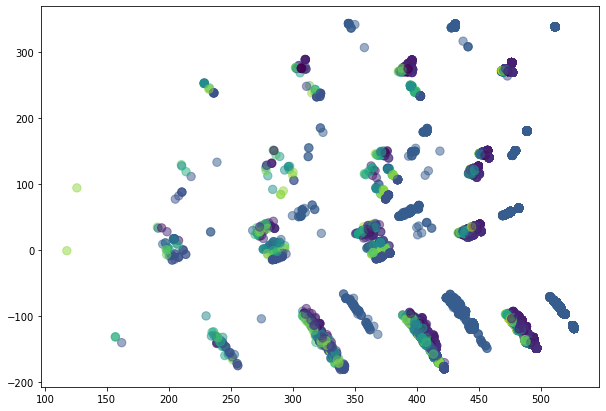

In [358]:
plt.figure(figsize=(10, 7))
plt.scatter(X2d[0], X2d[1], c = np.asarray(labels_industry).astype(float),s=70, alpha=0.5)

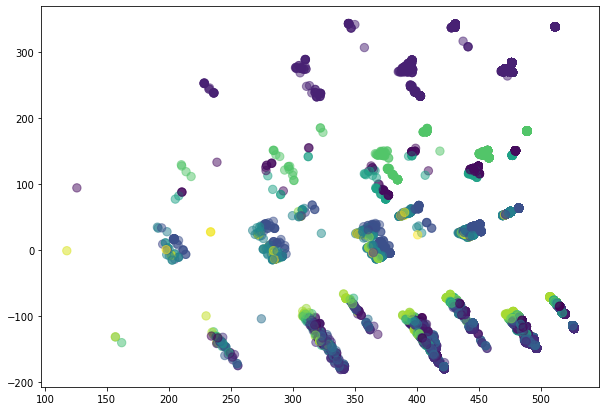

In [359]:
plt.figure(figsize=(10,7))
plt.scatter(X2d[0], X2d[1], c= np.asarray(labels_country).astype(float), s=70, alpha=0.5)

In [360]:
def dim_reduction(X2):
    famd = prince.FAMD(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
    famd = famd.fit(X2)
    X2d = famd.row_coordinates(X2)
    return X2d

### Create function to find the best number of cluster to maximize the silhouette score

In [361]:
def maximize_cluster_score(X2d, low_value, high_value):
    max_score = -1
    best_cluster_number = 0
    for i in range(low_value, high_value):
        kmeans = KMeans(n_clusters=i).fit(X2d)
        if silhouette_score(X2d, kmeans.labels_) > max_score:
            max_score = silhouette_score(X2d, kmeans.labels_)
            best_cluster_number = i
    return best_cluster_number, max_score

### Create function to run the model 

In [362]:
def get_clusters_per_column(X2, X2d, class_name, cluster_number):
    X2d_column = X2d[X2['country_industry'] == class_name]
    kmeans = KMeans(n_clusters=cluster_number).fit(X2d_column)
    y_kmeans = kmeans.predict(X2d_column)
    plt.figure(figsize=(10,7))
    plt.scatter(X2d_column[0], X2d_column[1], c= y_kmeans, s=800, cmap='viridis')
    plt.title(class_name)
    plt.xlabel("x")
    plt.ylabel("y")
    return kmeans.labels_, silhouette_score(X2d_column, kmeans.labels_), kmeans.cluster_centers_, X2d_column

In [363]:
len(X2['country_industry'])

16250

In [364]:
sum(X2['country_industry'] == 'FRANCE_Apparel')

544

In [365]:
sum(X2['country_industry'] == 'JAPAN_Apparel')

407

In [366]:
sum(X2['country_industry'] == 'UNITED STATES_Apparel')

1224

## Clustering for 3 chosen Country x Industry

In [367]:
df_FRANCE_Apparel = X[X['country_industry'] == 'FRANCE_Apparel']
df_FRANCE_Apparel_copy = X[X['country_industry'] == 'FRANCE_Apparel']
df_FRANCE_Apparel = df_FRANCE_Apparel.reset_index()

In [368]:
df_JAPAN_Apparel = X[X['country_industry'] == 'JAPAN_Apparel']
df_JAPAN_Apparel_copy = X[X['country_industry'] == 'JAPAN_Apparel']
df_JAPAN_Apparel = df_JAPAN_Apparel.reset_index()

In [369]:
df_UNITED_STATES_Apparel = X[X['country_industry'] == 'UNITED STATES_Apparel']
df_UNITED_STATES_Apparel_copy = X[X['country_industry'] == 'UNITED STATES_Apparel']
df_UNITED_STATES_Apparel = df_UNITED_STATES_Apparel.reset_index()

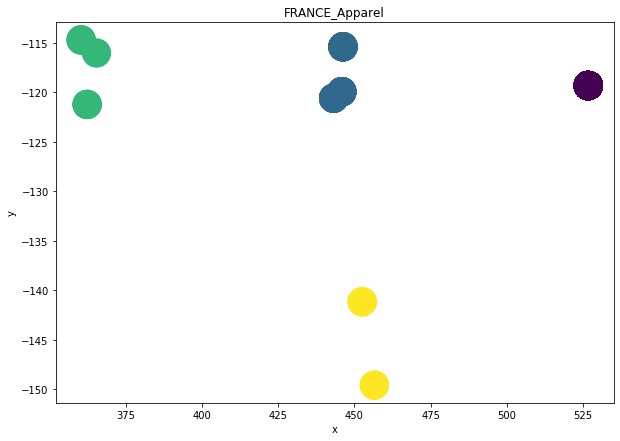

In [370]:
df_FRANCE_Apparel['labels'], s1, c1, X2d_france = get_clusters_per_column(X, X2d, 'FRANCE_Apparel', 4)

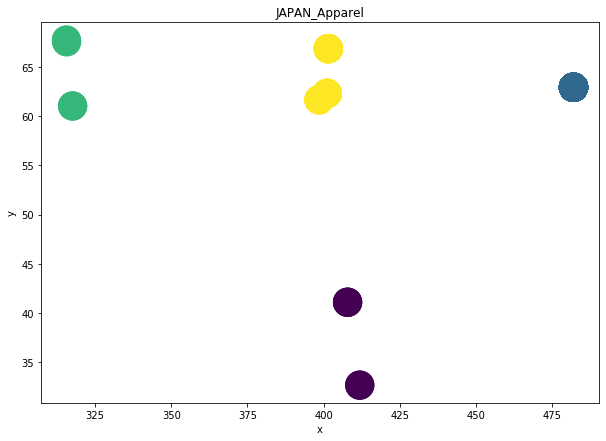

In [371]:
df_JAPAN_Apparel['labels'], s2, c2, X2d_japan = get_clusters_per_column(X, X2d, 'JAPAN_Apparel', 4)

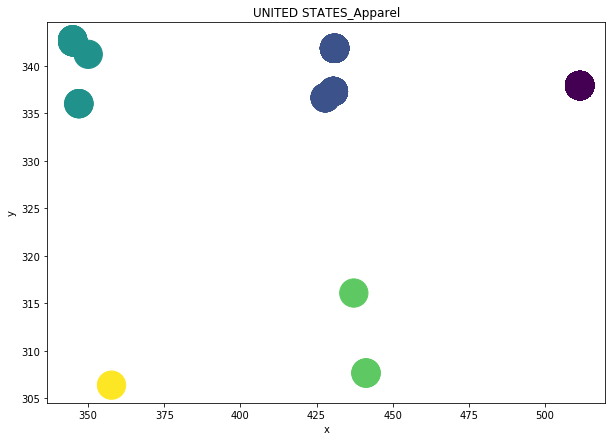

In [372]:
df_UNITED_STATES_Apparel['labels'], s3, c3, X2d_us = get_clusters_per_column(X, X2d, 'UNITED STATES_Apparel', 5)

In [373]:
df_FRANCE_Apparel.to_csv('FRANCE_Apparel.csv')

In [374]:
df_JAPAN_Apparel.to_csv('JAPAN_Apparel.csv')

In [375]:
df_UNITED_STATES_Apparel.to_csv('UNITED_STATES_Apparel.csv')

# We got very high silhouette score !

In [419]:
print(s1,s2,s3)

0.9902152699203981 0.9907748642383635 0.989359765960901


In [420]:
ind_france = list((X[X['country_industry'] == 'FRANCE_Apparel']).index)

In [421]:
ind_japan = list((X[X['country_industry'] == 'JAPAN_Apparel']).index)

In [422]:
ind_us = list((X[X['country_industry'] == 'UNITED STATES_Apparel']).index)

In [423]:
## Map new indices to the old ones
def get_dict(ind, length):
    new_dict = dict()
    for i in range(length):
        new_dict[i] = ind[i]
    return new_dict

In [424]:
dict_france = get_dict(ind_france, df_FRANCE_Apparel.shape[0])
dict_japan = get_dict(ind_japan, df_JAPAN_Apparel.shape[0])
dict_us = get_dict(ind_us, df_UNITED_STATES_Apparel.shape[0])

## Get average clients in each cluster

In [425]:
def get_average_clients(df, X2d, centroids):
    row_labels = []
    labels = list(df['labels'])
    for label in set(labels):
        row_list = []
        for i in range(len(X2d)):
            if labels[i] == label:
                row_list.append(i)
        row_labels.append(row_list)
    
    average_clients = []
    for i in range(len(centroids)):
        min_dist = -1
        ind_min = 0
        for j in range(len(row_labels[i])):
            if min_dist == -1 or (X2d[row_labels[i][j]][0] - centroids[i][0])*(X2d[row_labels[i][j]][0] - centroids[i][0]) + (X2d[row_labels[i][j]][1] - centroids[i][1])*(X2d[row_labels[i][j]][1] - centroids[i][1]) < min_dist:
                min_dist = (X2d[row_labels[i][j]][0] - centroids[i][0])*(X2d[row_labels[i][j]][0] - centroids[i][0]) + (X2d[row_labels[i][j]][1] - centroids[i][1])*(X2d[row_labels[i][j]][1] - centroids[i][1])
                ind_min = row_labels[i][j]
        average_clients.append(ind_min)
    return average_clients

In [426]:
X2d_france_arr = X2d_france.to_numpy()
X2d_japan_arr = X2d_japan.to_numpy()
X2d_us_arr = X2d_us.to_numpy()

In [427]:
#Getting number of clusters that maximizes silhouette score
c_france = maximize_cluster_score(X2d_france, 3, 30)
c_japan = maximize_cluster_score(X2d_japan, 3, 30)
c_us = maximize_cluster_score(X2d_us, 3, 30)

In [428]:
print(c_france, c_japan, c_us)

(9, 0.9981490564462092) (8, 0.9998422306115123) (11, 0.9975237156053496)


In [429]:
average_clients_france = get_average_clients(df_FRANCE_Apparel, X2d_france_arr, c1)
average_clients_japan = get_average_clients(df_JAPAN_Apparel, X2d_japan_arr, c2)
average_clients_us = get_average_clients(df_UNITED_STATES_Apparel, X2d_us_arr, c3)

In [387]:
#Getting indices for clients in the original dataset
def get_index_client(dict_var, expected_var):
    index_client = []
    for i in range(len(expected_var)):
        index_client.append(dict_var[expected_var[i]])
    return index_client

In [388]:
ind_exp_france = get_index_client(dict_france, average_clients_france)
ind_exp_japan = get_index_client(dict_japan, average_clients_japan)
ind_exp_us = get_index_client(dict_us, average_clients_us)

In [389]:
ind_exp_france

[7923, 9524, 10303, 1540]

In [390]:
ind_exp_japan

[15937, 14677, 12847, 1411]

In [391]:
ind_exp_us

[8721, 14139, 14398, 12039, 4142]

In [392]:
##Get clients in the original dataset
def get_clients(ind_exp):
    clients = []
    for i in range(len(ind_exp)):
        clients.append(X['unique_client'][ind_exp[i]])
    return clients

In [393]:
clients_france = get_clients(ind_exp_france)
clients_japan = get_clients(ind_exp_japan)
clients_us = get_clients(ind_exp_us)

In [394]:
clients_france

['ga_a2c851c7-7c38-e211-9847-000c29ae377c_FRANCE',
 'ga_1acf51c7-7c38-e211-9847-000c29ae377c_FRANCE',
 'ga_db07009b-ed73-e511-9606-005056bb2344_FRANCE',
 '962e4ce2-4b06-3c00-eba7-1a2717783027_FRANCE']

In [395]:
clients_japan

['ga_8fd2bab0-9fb5-e511-9606-005056bb2344_JAPAN',
 'ga_da1733da-7c38-e211-9847-000c29ae377c_JAPAN',
 'c9dcf697-5b42-bea2-4410-08634a484fed_JAPAN',
 'ga_98ad51c7-7c38-e211-9847-000c29ae377c_JAPAN']

In [396]:
clients_us

['ga_a5cce4c2-33a6-e311-b5d4-005056bb7e02_UNITED STATES',
 'ga_51106280-082b-e511-9606-005056bb2344_UNITED STATES',
 'ga_8e7a133d-fbda-e511-9606-005056bb2344_UNITED STATES',
 'ga_506bb33e-88a5-e411-b0d2-005056bb7e02_UNITED STATES',
 'eb63f8dc-5363-c395-eb56-ea2246c5cf21_UNITED STATES']

In [397]:
df_france_clients = X.iloc[ind_exp_france,:]
df_japan_clients = X.iloc[ind_exp_japan,:]
df_us_clients = X.iloc[ind_exp_us,:]

In [398]:
df_france_clients.to_csv('france_clients.csv')
df_japan_clients.to_csv('japan_clients.csv')
df_us_clients.to_csv('us_clients.csv')

## Get best client in each cluster

In [399]:
df_FRANCE_Apparel = df_FRANCE_Apparel.fillna(0)
for i in range(df_FRANCE_Apparel.shape[0]):
    df_FRANCE_Apparel.loc[i,'duration'] = float(df_FRANCE_Apparel['churn_date_pred'][i]) - float(df_FRANCE_Apparel['time'][i])

    
df_JAPAN_Apparel = df_JAPAN_Apparel.fillna(0)
for i in range(df_JAPAN_Apparel.shape[0]):
    df_JAPAN_Apparel.loc[i,'duration'] = float(df_JAPAN_Apparel['churn_date_pred'][i]) - float(df_JAPAN_Apparel['time'][i])
    
    
df_UNITED_STATES_Apparel = df_UNITED_STATES_Apparel.fillna(0)
for i in range(df_UNITED_STATES_Apparel.shape[0]):
    df_UNITED_STATES_Apparel.loc[i,'duration'] = float(df_UNITED_STATES_Apparel['churn_date_pred'][i]) - float(df_UNITED_STATES_Apparel['time'][i])
    

In [400]:
def rep_clients_per_cluster_FR(df_FRANCE_Apparel):
    best_clients = []
    labels = list(df_FRANCE_Apparel['labels'])
    set_labels = set(labels)
    labels_quant = len(set_labels)
    for i in range(labels_quant):
        df_cluster = df_FRANCE_Apparel[df_FRANCE_Apparel['labels'] == i]
        min_churn_date = -1
        max_churn_date = -1
        ind_min = 0
        ind_max = 0
        for j, row in df_cluster.iterrows():
            if df_cluster['duration'][j] > max_churn_date:
                max_churn_date = df_cluster['duration'][j]
                ind_max = j
            if min_churn_date == -1 or df_cluster['duration'][j] < min_churn_date:
                min_churn_date = df_cluster['duration'][j]
                ind_min = j
        best_clients.append(ind_max)
    return (best_clients)


def rep_clients_per_cluster_JP(df_JAPAN_Apparel):
    best_clients = []
    labels = list(df_JAPAN_Apparel['labels'])
    set_labels = set(labels)
    labels_quant = len(set_labels)
    for i in range(labels_quant):
        df_cluster = df_JAPAN_Apparel[df_JAPAN_Apparel['labels'] == i]
        min_churn_date = -1
        max_churn_date = -1
        ind_min = 0
        ind_max = 0
        for j, row in df_cluster.iterrows():
            if df_cluster['duration'][j] > max_churn_date:
                max_churn_date = df_cluster['duration'][j]
                ind_max = j
            if min_churn_date == -1 or df_cluster['duration'][j] < min_churn_date:
                min_churn_date = df_cluster['duration'][j]
                ind_min = j
        best_clients.append(ind_max)
    return (best_clients)

def rep_clients_per_cluster_US(df_UNITED_STATES_Apparel):
    best_clients = []
    labels = list(df_UNITED_STATES_Apparel['labels'])
    set_labels = set(labels)
    labels_quant = len(set_labels)
    for i in range(labels_quant):
        df_cluster = df_UNITED_STATES_Apparel[df_UNITED_STATES_Apparel['labels'] == i]
        min_churn_date = -1
        max_churn_date = -1
        ind_min = 0
        ind_max = 0
        for j, row in df_cluster.iterrows():
            if df_cluster['duration'][j] > max_churn_date:
                max_churn_date = df_cluster['duration'][j]
                ind_max = j
            if min_churn_date == -1 or df_cluster['duration'][j] < min_churn_date:
                min_churn_date = df_cluster['duration'][j]
                ind_min = j
        best_clients.append(ind_max)
    return (best_clients)

In [401]:
best_clients_france = rep_clients_per_cluster_FR(df_FRANCE_Apparel)

In [402]:
#Indices in the cluster dataframe
best_clients_france

[146, 37, 539, 44]

In [403]:
best_clients_japan = rep_clients_per_cluster_JP(df_JAPAN_Apparel)

In [404]:
#Indices in the cluster dataframe
best_clients_japan

[260, 90, 399, 140]

In [405]:
best_clients_us = rep_clients_per_cluster_US(df_UNITED_STATES_Apparel)

In [406]:
#Indices in the cluster dataframe
best_clients_us

[731, 367, 1208, 28, 320]

In [407]:
#Indices in the original dataframe
ind_best_france = get_index_client(dict_france, best_clients_france)
ind_best_japan = get_index_client(dict_japan, best_clients_japan)
ind_best_us = get_index_client(dict_us, best_clients_us)

In [408]:
ind_best_france

[4632, 1326, 16023, 1540]

## Append clients IDs to he original dataframe

In [409]:
get_clients(ind_best_france)

['5a9f9ccf-e847-9940-4823-ce747bd2e6d2_FRANCE',
 'ga_cc58808f-1ee3-e411-9606-005056bb2344_FRANCE',
 'ga_3d322f95-123b-e211-9847-000c29ae377c_FRANCE',
 '962e4ce2-4b06-3c00-eba7-1a2717783027_FRANCE']

In [410]:
get_clients(ind_best_japan)

['8df3cd43-e950-7919-30f7-169a5758563a_JAPAN',
 'ga_7cc451c7-7c38-e211-9847-000c29ae377c_JAPAN',
 'ga_3d322f95-123b-e211-9847-000c29ae377c_JAPAN',
 '1f04248e-5506-30d7-dabf-27eee12f8ad2_JAPAN']

In [411]:
get_clients(ind_best_us)

['ga_e2824d59-5d7a-e411-b0d2-005056bb7e02_UNITED STATES',
 'ga_96bc51c7-7c38-e211-9847-000c29ae377c_UNITED STATES',
 'ga_3d322f95-123b-e211-9847-000c29ae377c_UNITED STATES',
 'ga_ed7d17e4-aa86-e211-a813-005056bb2836_UNITED STATES',
 'eb63f8dc-5363-c395-eb56-ea2246c5cf21_UNITED STATES']

In [412]:
df_france_best = X.iloc[ind_best_france,:]
df_japan_best = X.iloc[ind_best_japan,:]
df_us_best = X.iloc[ind_best_us,:]

In [413]:
df_france_best.to_csv('france_best.csv')
df_japan_best.to_csv('japan_best.csv')
df_us_best.to_csv('us_best.csv')

# Indicate the difference between the best and the average client by country, indusrty, cluster, to suggest next strategy

In [459]:
X.columns

Index(['unique_client', 'month', 'time', 'vertical', 'industry',
       'client_country', 'client_continent', 'client_region', 'OS', 'device',
       'environment', 'criteo_product', 'spend_criteo_euro', 'sales_criteo',
       'CPO', 'revenue_criteo_euro', 'AOV', 'COS', 'Android', 'MacOS', 'Other',
       'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration',
       'conversion', 'products', 'onsite_sales', 'onsite_revenue_euro',
       'churn_date', 'country_industry'],
      dtype='object')

In [460]:
df3 = X[['spend_criteo_euro', 'sales_criteo',
       'CPO', 'revenue_criteo_euro', 'AOV', 'COS', 'Android', 'MacOS', 'Other',
       'iOs', 'Desktop', 'Mobile', 'app', 'web', 'awareness', 'consideration',
       'conversion', 'products', 'onsite_sales', 'onsite_revenue_euro',
       'country_industry']]

In [465]:
df3.columns

Index(['spend_criteo_euro', 'sales_criteo', 'CPO', 'revenue_criteo_euro',
       'AOV', 'COS', 'Android', 'MacOS', 'Other', 'iOs', 'Desktop', 'Mobile',
       'app', 'web', 'awareness', 'consideration', 'conversion', 'products',
       'onsite_sales', 'onsite_revenue_euro', 'country_industry'],
      dtype='object')

In [466]:
def indicate_changements(df3, average_clients, best_clients):
    for i in range(len(average_clients)):
        print('Difference from the Best Client ', i)
        for column in df3:
            if column != 'client_country' and column != 'client_region' and column != 'time' and column != 'unique_client' and column != 'churn_date':
                if df3[column][average_clients[i]] != df3[column][best_clients[i]]:
                    print('change value', column, 'to ', df3[column][best_clients[i]])

In [467]:
indicate_changements(df_FRANCE_Apparel, average_clients_france, best_clients_france)

Difference from the Best Client  0
change value index to  4632
change value spend_criteo_euro to  107523
change value sales_criteo to  4485
change value CPO to  24.0
change value revenue_criteo_euro to  420841
change value AOV to  94.0
change value Android to  107523.0
change value Mobile to  107523.0
change value web to  107523.0
change value conversion to  107523.0
change value products to  3228.0
change value onsite_sales to  10019.0
change value onsite_revenue_euro to  27906488.35
change value churn_date_pred to  2024.07
change value duration to  7.039999999999964
Difference from the Best Client  1
change value index to  1326
change value month to  12
change value environment to  app
change value criteo_product to  conversion
change value spend_criteo_euro to  20
change value sales_criteo to  12
change value CPO to  2.0
change value revenue_criteo_euro to  757
change value AOV to  63.0
change value Android to  20.0
change value Mobile to  20.0
change value app to  20.0
change value

In [463]:
indicate_changements(df_JAPAN_Apparel, average_clients_japan, best_clients_japan)

Difference from the Best Client  0
change calue index to  12030
change calue month to  8
change calue spend_criteo_euro to  21196
change calue sales_criteo to  1424
change calue CPO to  15.0
change calue revenue_criteo_euro to  8
change calue AOV to  0.0
change calue COS to  2717
change calue Android to  21196.0
change calue Mobile to  21196.0
change calue web to  21196.0
change calue conversion to  21196.0
change calue products to  31859.0
change calue onsite_sales to  136.0
change calue onsite_revenue_euro to  121635.1
change calue churn_date_pred to  2025.06
change calue duration to  5.980000000000018
Difference from the Best Client  1
change calue index to  3749
change calue spend_criteo_euro to  106166
change calue sales_criteo to  7742
change calue CPO to  14.0
change calue revenue_criteo_euro to  481812
change calue AOV to  62.0
change calue Android to  106166.0
change calue Mobile to  106166.0
change calue web to  106166.0
change calue conversion to  106166.0
change calue produ

In [464]:
indicate_changements(df_UNITED_STATES_Apparel, average_clients_us, best_clients_us)

Difference from the Best Client  0
change calue index to  10121
change calue spend_criteo_euro to  149920
change calue sales_criteo to  238
change calue CPO to  630.0
change calue revenue_criteo_euro to  237851
change calue AOV to  999.0
change calue Android to  149920.0
change calue Mobile to  149920.0
change calue web to  149920.0
change calue conversion to  149920.0
change calue products to  59918.0
change calue onsite_sales to  199.0
change calue onsite_revenue_euro to  14972.98
change calue churn_date_pred to  2025.02
change calue duration to  7.990000000000009
Difference from the Best Client  1
change calue index to  4913
change calue month to  5
change calue device to  Mobile
change calue environment to  app
change calue spend_criteo_euro to  3409
change calue sales_criteo to  62
change calue CPO to  55.0
change calue revenue_criteo_euro to  30265
change calue AOV to  488.0
change calue Android to  3409.0
change calue Desktop to  0.0
change calue Mobile to  3409.0
change calue a